1. Setup & Imports

In [1]:
# Essential Libraries
import numpy as np
import pandas as pd
import os
import cv2
import random
import shutil

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.utils import shuffle

# Keras & TensorFlow
from keras.models import Sequential, save_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

# Kaggle Setup
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle --version


Kaggle API 1.7.4.5



2. Data Loading Function

In [2]:
# Create a directory to store datasets
!mkdir -p ./datasets

# Download datasets from Kaggle (use dataset "slugs")
!kaggle datasets download -d prashant268/chest-xray-covid19-pneumonia -p ./datasets
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p ./datasets

# Note: The downloaded filenames are usually the last part of the slug.
!unzip -q ./datasets/chest-xray-covid19-pneumonia.zip -d ./datasets/dataset1
!unzip -q ./datasets/chest-xray-pneumonia.zip -d ./datasets/dataset2

# Optional: clean up zip files
!rm -rf ./datasets/*.zip

def load_data(data_dir, img_size=150):
    """
    Fixed loading function with consistent label encoding
    PNEUMONIA = 1 (positive class for binary classification)
    NORMAL = 0 (negative class)
    """
    data = []
    label_map = {'NORMAL': 0, 'PNEUMONIA': 1}  # FIX: Explicit mapping

    for label_name, label_value in label_map.items():
        path = os.path.join(data_dir, label_name)
        if not os.path.exists(path):
            print(f"Warning: {label_name} folder not found in {data_dir}")
            continue

        img_count = 0
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img_arr is not None:
                    resized_arr = cv2.resize(img_arr, (img_size, img_size))
                    data.append([resized_arr, label_value])
                    img_count += 1
            except Exception as e:
                print(f"Error reading {img_path}: {e}")

        print(f"Loaded {img_count} {label_name} images from {data_dir}")

    return data

Dataset URL: https://www.kaggle.com/datasets/prashant268/chest-xray-covid19-pneumonia
License(s): unknown
 99% 2.03G/2.06G [00:19<00:00, 217MB/s]
100% 2.06G/2.06G [00:19<00:00, 115MB/s]
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:17<00:00, 237MB/s]
100% 2.29G/2.29G [00:17<00:00, 143MB/s]


3. Load Multiple Datasets


In [3]:
# This will only read PNEUMONIA and NORMAL
print("Loading Dataset 1: chest-xray-covid19-pneumonia")
train1 = load_data("./datasets/dataset1/Data/train")
test1 = load_data("./datasets/dataset1/Data/test")

print("Loading Dataset 2: chest-xray-pneumonia")
train2 = load_data("./datasets/dataset2/chest_xray/train")
val2 = load_data("./datasets/dataset2/chest_xray/val")
test2 = load_data("./datasets/dataset2/chest_xray/test")

Loading Dataset 1: chest-xray-covid19-pneumonia
Loaded 1266 NORMAL images from ./datasets/dataset1/Data/train
Loaded 3418 PNEUMONIA images from ./datasets/dataset1/Data/train
Loaded 317 NORMAL images from ./datasets/dataset1/Data/test
Loaded 855 PNEUMONIA images from ./datasets/dataset1/Data/test
Loading Dataset 2: chest-xray-pneumonia
Loaded 1341 NORMAL images from ./datasets/dataset2/chest_xray/train
Loaded 3875 PNEUMONIA images from ./datasets/dataset2/chest_xray/train
Loaded 8 NORMAL images from ./datasets/dataset2/chest_xray/val
Loaded 8 PNEUMONIA images from ./datasets/dataset2/chest_xray/val
Loaded 234 NORMAL images from ./datasets/dataset2/chest_xray/test
Loaded 390 PNEUMONIA images from ./datasets/dataset2/chest_xray/test


4. Preprocess & Combine Data

In [4]:
# Preprocessing function
IMG_SIZE = 150
def preprocess(data):
    X = np.array([i[0] for i in data]).reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 255.0
    y = np.array([i[1] for i in data])
    return X, y


# Process all datasets
X_train1, y_train1 = preprocess(train1)
X_test1, y_test1 = preprocess(test1)

X_train2, y_train2 = preprocess(train2)
X_test2, y_test2 = preprocess(test2)
X_val, y_val = preprocess(val2)


# Combine training data
X_train = np.concatenate((X_train1, X_train2), axis=0)
y_train = np.concatenate((y_train1, y_train2), axis=0)

# Combine test data
X_test = np.concatenate((X_test1, X_test2), axis=0)
y_test = np.concatenate((y_test1, y_test2), axis=0)

# Shuffle combined data
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

# Create proper validation split (20% of training)
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    X_train, y_train,
    test_size=0.2,  # 20% validation
    random_state=42,
    stratify=y_train
)

print("\n=== Final Dataset Shapes ===")
print(f"Training: {X_train_final.shape}, Labels: {y_train_final.shape}")
print(f"Validation: {X_val_final.shape}, Labels: {y_val_final.shape}")
print(f"Test: {X_test.shape}, Labels: {y_test.shape}")

print("\n=== Class Distribution (0=Normal, 1=Pneumonia) ===")
print(f"Train - Normal: {np.sum(y_train_final==0)}, Pneumonia: {np.sum(y_train_final==1)}")
print(f"Val - Normal: {np.sum(y_val_final==0)}, Pneumonia: {np.sum(y_val_final==1)}")
print(f"Test - Normal: {np.sum(y_test==0)}, Pneumonia: {np.sum(y_test==1)}")


=== Final Dataset Shapes ===
Training: (7920, 150, 150, 1), Labels: (7920,)
Validation: (1980, 150, 150, 1), Labels: (1980,)
Test: (1796, 150, 150, 1), Labels: (1796,)

=== Class Distribution (0=Normal, 1=Pneumonia) ===
Train - Normal: 2086, Pneumonia: 5834
Val - Normal: 521, Pneumonia: 1459
Test - Normal: 551, Pneumonia: 1245


5. Data Augmentation


In [5]:
train_datagen = ImageDataGenerator(
    rotation_range=15,        # Reduced from 30
    zoom_range=0.1,          # Reduced from 0.2
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'      # Added fill mode
)

# No augmentation for validation
val_datagen = ImageDataGenerator()

6. Build CNN Model


In [8]:
def create_model():
    model = Sequential([
        # Block 1
        Conv2D(32, (3,3), activation='relu', padding='same',
               input_shape=(IMG_SIZE, IMG_SIZE, 1)),
        BatchNormalization(),
        Conv2D(32, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(2, 2),
        Dropout(0.25),

        # Block 2
        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(2, 2),
        Dropout(0.25),

        # Block 3
        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(2, 2),
        Dropout(0.25),

        # Dense layers
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        # Output layer
        Dense(1, activation='sigmoid')
    ])

    return model

model = create_model()

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 150, 150, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 37, 37, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    10,617,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 10,939,873 (41.73 MB)

 Trainable params: 10,938,209 (41.73 MB)

 Non-trainable params: 1,664 (6.50 KB)

7. Train the Model


In [11]:
# Create callbacks
callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',  # Monitor validation loss instead
        patience=3,
        factor=0.5,
        min_lr=1e-7,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_auc',  # Monitor AUC for best model
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

# Train with fixed batch size and steps
BATCH_SIZE = 32
EPOCHS = 30

steps_per_epoch = len(X_train_final) // BATCH_SIZE
validation_steps = len(X_val_final) // BATCH_SIZE

print(f"\nTraining with {steps_per_epoch} steps per epoch")
print(f"Validation with {validation_steps} steps")

history = model.fit(
    train_datagen.flow(X_train_final, y_train_final, batch_size=BATCH_SIZE),
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_datagen.flow(X_val_final, y_val_final, batch_size=BATCH_SIZE),
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)


Training with 247 steps per epoch
Validation with 61 steps
Epoch 1/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.7886 - auc: 0.8688 - loss: 0.5164
Epoch 1: val_auc improved from -inf to 0.46374, saving model to best_model.h5


247/247 ━━━━━━━━━━━━━━━━━━━━ 56s 143ms/step - accuracy: 0.7889 - auc: 0.8690 - loss: 0.5158 - val_accuracy: 0.7331 - val_auc: 0.4637 - val_loss: 2.8783 - learning_rate: 0.0010
Epoch 2/30
  1/247 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.9062 - auc: 0.9727 - loss: 0.1981
Epoch 2: val_auc improved from 0.46374 to 0.50000, saving model to best_model.h5


247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9062 - auc: 0.9727 - loss: 0.1981 - val_accuracy: 0.7351 - val_auc: 0.5000 - val_loss: 4.8271 - learning_rate: 0.0010
Epoch 3/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9071 - auc: 0.9515 - loss: 0.2509
Epoch 3: val_auc improved from 0.50000 to 0.76833, saving model to best_model.h5


247/247 ━━━━━━━━━━━━━━━━━━━━ 82s 214ms/step - accuracy: 0.9071 - auc: 0.9515 - loss: 0.2509 - val_accuracy: 0.7372 - val_auc: 0.7683 - val_loss: 1.4275 - learning_rate: 0.0010
Epoch 4/30
  1/247 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.8438 - auc: 0.8000 - loss: 0.5127
Epoch 4: val_auc improved from 0.76833 to 0.78077, saving model to best_model.h5


247/247 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8438 - auc: 0.8000 - loss: 0.5127 - val_accuracy: 0.7392 - val_auc: 0.7808 - val_loss: 1.3999 - learning_rate: 0.0010
Epoch 5/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9191 - auc: 0.9617 - loss: 0.2218
Epoch 5: val_auc improved from 0.78077 to 0.98405, saving model to best_model.h5


247/247 ━━━━━━━━━━━━━━━━━━━━ 46s 90ms/step - accuracy: 0.9191 - auc: 0.9618 - loss: 0.2217 - val_accuracy: 0.9595 - val_auc: 0.9841 - val_loss: 0.1333 - learning_rate: 0.0010
Epoch 6/30
  1/247 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.9688 - auc: 0.9911 - loss: 0.1528
Epoch 6: val_auc improved from 0.98405 to 0.98480, saving model to best_model.h5


247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9688 - auc: 0.9911 - loss: 0.1528 - val_accuracy: 0.9600 - val_auc: 0.9848 - val_loss: 0.1300 - learning_rate: 0.0010
Epoch 7/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9323 - auc: 0.9727 - loss: 0.1808
Epoch 7: val_auc did not improve from 0.98480
247/247 ━━━━━━━━━━━━━━━━━━━━ 40s 163ms/step - accuracy: 0.9323 - auc: 0.9727 - loss: 0.1808 - val_accuracy: 0.3366 - val_auc: 0.6612 - val_loss: 5.0259 - learning_rate: 0.0010
Epoch 8/30
  1/247 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0549
Epoch 8: val_auc did not improve from 0.98480
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0549 - val_accuracy: 0.3350 - val_auc: 0.6521 - val_loss: 5.1336 - learning_rate: 0.0010
Epoch 9/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9424 - auc: 0.9769 - loss: 0.1644
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoc

247/247 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.9547 - auc: 0.9834 - loss: 0.1355 - val_accuracy: 0.9185 - val_auc: 0.9900 - val_loss: 0.2236 - learning_rate: 2.5000e-04
Epoch 14/30
  1/247 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9062 - auc: 0.9740 - loss: 0.2546
Epoch 14: val_auc improved from 0.98999 to 0.99009, saving model to best_model.h5


247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9062 - auc: 0.9740 - loss: 0.2546 - val_accuracy: 0.9201 - val_auc: 0.9901 - val_loss: 0.2197 - learning_rate: 2.5000e-04
Epoch 15/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9517 - auc: 0.9830 - loss: 0.1353
Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 15: val_auc improved from 0.99009 to 0.99014, saving model to best_model.h5


247/247 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/step - accuracy: 0.9517 - auc: 0.9830 - loss: 0.1354 - val_accuracy: 0.9488 - val_auc: 0.9901 - val_loss: 0.1317 - learning_rate: 2.5000e-04
Epoch 16/30
  1/247 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - accuracy: 0.8750 - auc: 0.9662 - loss: 0.2117
Epoch 16: val_auc improved from 0.99014 to 0.99025, saving model to best_model.h5


247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8750 - auc: 0.9662 - loss: 0.2117 - val_accuracy: 0.9508 - val_auc: 0.9903 - val_loss: 0.1280 - learning_rate: 1.2500e-04
Epoch 17/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9615 - auc: 0.9817 - loss: 0.1265
Epoch 17: val_auc improved from 0.99025 to 0.99124, saving model to best_model.h5


247/247 ━━━━━━━━━━━━━━━━━━━━ 41s 108ms/step - accuracy: 0.9615 - auc: 0.9817 - loss: 0.1265 - val_accuracy: 0.9365 - val_auc: 0.9912 - val_loss: 0.1877 - learning_rate: 1.2500e-04
Epoch 18/30
  1/247 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0694
Epoch 18: val_auc improved from 0.99124 to 0.99132, saving model to best_model.h5


247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0694 - val_accuracy: 0.9390 - val_auc: 0.9913 - val_loss: 0.1799 - learning_rate: 1.2500e-04
Epoch 19/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9593 - auc: 0.9861 - loss: 0.1220
Epoch 19: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 19: val_auc did not improve from 0.99132
247/247 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - accuracy: 0.9593 - auc: 0.9861 - loss: 0.1221 - val_accuracy: 0.7382 - val_auc: 0.9691 - val_loss: 0.6742 - learning_rate: 1.2500e-04
Epoch 20/30
  1/247 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9375 - auc: 0.9943 - loss: 0.1167
Epoch 20: val_auc did not improve from 0.99132
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9375 - auc: 0.9943 - loss: 0.1167 - val_accuracy: 0.7382 - val_auc: 0.9691 - val_loss: 0.6780 - learning_rate: 6.2500e-05
Epoch 21/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9548 - auc: 0.9832 - l

247/247 ━━━━━━━━━━━━━━━━━━━━ 63s 91ms/step - accuracy: 0.9548 - auc: 0.9832 - loss: 0.1375 - val_accuracy: 0.9559 - val_auc: 0.9923 - val_loss: 0.1303 - learning_rate: 6.2500e-05
Epoch 22/30
  1/247 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.9688 - auc: 0.9955 - loss: 0.1051
Epoch 22: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 22: val_auc did not improve from 0.99229
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9688 - auc: 0.9955 - loss: 0.1051 - val_accuracy: 0.9565 - val_auc: 0.9921 - val_loss: 0.1289 - learning_rate: 6.2500e-05
Epoch 23/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9588 - auc: 0.9848 - loss: 0.1222
Epoch 23: val_auc did not improve from 0.99229
247/247 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - accuracy: 0.9588 - auc: 0.9848 - loss: 0.1222 - val_accuracy: 0.9185 - val_auc: 0.9895 - val_loss: 0.2363 - learning_rate: 3.1250e-05
Epoch 24/30
  1/247 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9375 - auc: 1.0000 

247/247 ━━━━━━━━━━━━━━━━━━━━ 41s 92ms/step - accuracy: 0.9585 - auc: 0.9872 - loss: 0.1191 - val_accuracy: 0.9606 - val_auc: 0.9926 - val_loss: 0.1260 - learning_rate: 3.1250e-05
Epoch 26/30
  1/247 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.9688 - auc: 1.0000 - loss: 0.0883
Epoch 26: val_auc did not improve from 0.99255
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9688 - auc: 1.0000 - loss: 0.0883 - val_accuracy: 0.9611 - val_auc: 0.9921 - val_loss: 0.1274 - learning_rate: 3.1250e-05
Epoch 27/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9572 - auc: 0.9839 - loss: 0.1290
Epoch 27: val_auc did not improve from 0.99255
247/247 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.9572 - auc: 0.9840 - loss: 0.1290 - val_accuracy: 0.9037 - val_auc: 0.9883 - val_loss: 0.2755 - learning_rate: 3.1250e-05
Epoch 28/30
  1/247 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0401
Epoch 28: ReduceLROnPlateau reducing learning rate to 1.5625000

8. Evaluate the Model


In [12]:
print("\n=== Model Evaluation ===")
test_loss, test_acc, test_auc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Make predictions
predictions = model.predict(X_test)
predicted_classes = (predictions > 0.5).astype(int).flatten()

print("\n=== Classification Report ===")
print(classification_report(y_test, predicted_classes,
                          target_names=['Normal', 'Pneumonia']))


=== Model Evaluation ===
Test Loss: 0.1746
Test Accuracy: 0.9360
Test AUC: 0.9808
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step

=== Classification Report ===
              precision    recall  f1-score   support

      Normal       0.90      0.89      0.90       551
   Pneumonia       0.95      0.96      0.95      1245

    accuracy                           0.94      1796
   macro avg       0.93      0.92      0.92      1796
weighted avg       0.94      0.94      0.94      1796



9. Make Predictions


In [13]:
print("First 15 predictions:")
print(predictions[:15].flatten())

# Print classification report
print(classification_report(y_test, predicted_classes, target_names=['Pneumonia (Class 0)', 'Normal (Class 1)']))

def sanity_check_predictions(model, X_test_sample, y_test_sample, n=10):
    """Check if model outputs make sense"""
    sample_preds = model.predict(X_test_sample[:n])

    print("\n=== Sanity Check - First 10 Predictions ===")
    for i in range(n):
        pred_prob = sample_preds[i][0]
        pred_class = 1 if pred_prob > 0.5 else 0
        true_class = y_test_sample[i]
        class_names = {0: "Normal", 1: "Pneumonia"}

        print(f"Sample {i+1}: True={class_names[true_class]}, "
              f"Pred={class_names[pred_class]} (prob={pred_prob:.3f})")

sanity_check_predictions(model, X_test, y_test, n=10)

print("\n✅ Model training complete! Check if predictions vary properly.")
print("If still seeing 50/50 predictions, the issue might be corrupted data or extreme overfitting.")

First 15 predictions:
[0.00957686 0.00638627 0.9959345  0.7537027  0.00730903 0.9957593
 0.99903494 0.3081393  0.9912778  0.9981775  0.97483987 0.99720365
 0.9536952  0.9764322  0.9782521 ]
                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.90      0.89      0.90       551
   Normal (Class 1)       0.95      0.96      0.95      1245

           accuracy                           0.94      1796
          macro avg       0.93      0.92      0.92      1796
       weighted avg       0.94      0.94      0.94      1796

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

=== Sanity Check - First 10 Predictions ===
Sample 1: True=Normal, Pred=Normal (prob=0.010)
Sample 2: True=Normal, Pred=Normal (prob=0.006)
Sample 3: True=Pneumonia, Pred=Pneumonia (prob=0.996)
Sample 4: True=Pneumonia, Pred=Pneumonia (prob=0.754)
Sample 5: True=Normal, Pred=Normal (prob=0.007)
Sample 6: True=Pneumonia, Pred=Pneumonia (prob=0.996)
Sample 7: True=Pneumonia, Pred=Pneumonia (prob=0.999)


10. Generate Evaluation Graphs


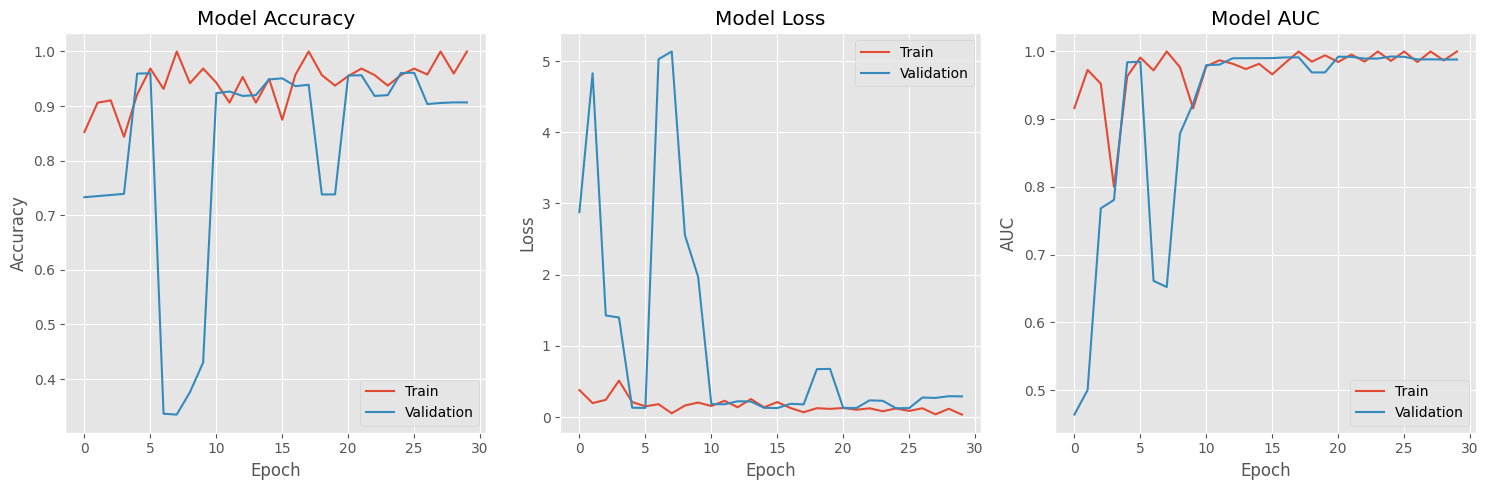

In [14]:
def plot_training_history(history):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Accuracy
    axes[0].plot(history.history['accuracy'], label='Train')
    axes[0].plot(history.history['val_accuracy'], label='Validation')
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)

    # Loss
    axes[1].plot(history.history['loss'], label='Train')
    axes[1].plot(history.history['val_loss'], label='Validation')
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)

    # AUC
    axes[2].plot(history.history['auc'], label='Train')
    axes[2].plot(history.history['val_auc'], label='Validation')
    axes[2].set_title('Model AUC')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('AUC')
    axes[2].legend()
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

11. Save the Model


In [16]:
# Save full model
save_model(model, 'pneumonia_detection.h5')
print("Model saved as 'pneumonia_detection.h5'")

# Create zip for download
shutil.make_archive('pneumonia_model', 'zip', '.', 'pneumonia_detection.h5')
print("Model zipped: 'pneumonia_model.zip'")

Model saved as 'pneumonia_detection.h5'
Model zipped: 'pneumonia_model.zip'
